## Neural Style Transfer

Have you ever wondered what a plane would look like in the painting style of van Gogh? Now you can find out!

Neural style transfer is a clever way of generating an image that has the *content* of one image and the *style* of another image.
In this lab, we'll implement a model for neural style transfer and you'll get to experiment with it on images of your choice.

Remember, a machine learning algorithm consists of:

1. **Model**. A model for computing a function of the input. In our problem, we'll use a way of extracting "content" and "style" information from an image. For this, we'll use the *intermediate* layers of a pretrained image classifier.

2. **Loss**. A way of quantifying the difference between a good "output" and a bad "output". In our problem, the loss will be low when the generated image is close in *style* to the style image and close in *content* to the content image.

3. **Optimizer**. A way of modifying the input to get a better output. In our problem, we'll run gradient descent on the *pixels* of the generated image to minimize the loss.

The hardest part of neural style transfer is figuring out how to extract content and style information for an image. For this purpose, we'll use a pretrained image classifier called a VGG19. Check out a diagram of the model below.

![image](https://viso.ai/wp-content/uploads/2021/10/vgg-neural-network-architecture.png)

As with most deep learning models, the VGG19 is  pretty complicated. However, we can get a good understanding of what it does by examining the input and output sizes. The input is a $224 \times 224 \times 3$ image which is transformed by a sequence of convolutional filters into a $1000$ length vector representing different classes. For our problem, we care about the *intermediate* features in the model.

Intuitively, the intermediate features of the image capture important information about what the image contains. For example, we may expect earlier features to hold more granular information (e.g. edges and shapes) while later features hold more abstract information (e.g. wheels and eyes). From an intermediate feature, we can easily get *content* information by simply looking at the values of the features.

It's less obvious how to extract *style* information. But it turns out taking the gram matrix of the intermediate features--the product of a matrix and its transpose--gives a good approximation to style. A mathematical explanation of why this works is given in Sections 2 and 3 of the paper [Demystifying Neural Style Transfer](https://arxiv.org/pdf/1701.01036.pdf).

Now that we have a way of quantifying the content and style of an image, we can compare the style and content of the generated image to the style and content images, respectively. In particular, we compute content loss as the mean squared difference between the intermediate features of the generated image and content image. Similarly, we compute style loss as the mean squared difference between the gram matrix as the intermediate features of the generated image and style image. Then we define the total loss as the sum of the style and content loss and, with gradient descent, we optimize the pixels of the generated image.

As usual, we'll begin by importing several helpful libraries.

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms, models
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
import cv2
import os


If it's available, we'll use a graphics processing unit (GPU) to make our code run faster. GPUs are faster because they have been optimized for matrix multiplication (lots of parallel computations) and, when cleverly implemented, evaluating a model and backpropagating through it are fancy matrix multiplications.

Note: If you're running the notebook on colab.research.google.com, you can get a GPU selecting Runtime > Change runtime type > Hardware accelerator > GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We'll now load a pretrained image classification model. Since we won't change its weights, we'll set the model to evaluation mode. And, to use the model on the GPU, we'll put it on the the `device` we just defined.

In [ ]:
model = models.vgg19(pretrained=True).features
model = model.eval() # evaluation mode (we won't change the weights of the model)
model = model.to(device) # putting it on the GPU (if we have one)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

It's always a good idea to count the number of parameters in the model to understand its complexity. Let's print out the number of parameters in the model below. 

In [ ]:
# Counting the number of parameters in the VGG19.
# Print out the number of parameters in the model.
sum([p.numel() for p in model.parameters()])

20024384

Let's also take a look at what's going on in the model.

In [ ]:
# Print out the model architecture.
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

A lot of convolutional, ReLU, and pooling layers! We'll use the features after the first several convolutional layers to extract content and style information.

Next, we'll load the style image and the content image. First, we'll specify the image size `imsize` based on whether we have a GPU to work with or not. Then we'll write a function which reshapes an image and turns it into a tensor.

In [ ]:
# If we have a GPU, we can make a larger image.
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
  transforms.Resize((imsize, imsize)), # Resize the image
  transforms.ToTensor(), # Format the picture so we can feed it to the model
])

We'll write a function to load an image from a link, apply our `loader` function, add a singleton batch dimension so we can pass through our model, and finally put it on `device`.

In [ ]:
def load_image(link, filename):
  urllib.request.urlretrieve(link, f'{filename}.png') # Save link as an image.
  image = Image.open(f'{filename}.png') # Load saved image.
  image = loader(image).unsqueeze(0) # Make a singleton batch for the model.
  return image.to(device) # Put the image on the device that the model is on.

# Some fun style links:
style_link = "https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg"
style_link = "https://i.ytimg.com/vi/WQlCGBszCg0/maxresdefault.jpg"
style_link = "https://www.vangoghstudio.com//Files/6/102000/102147/ProductPhotos/Source/307257209.jpg"

# Some fun content links:
content_link = "https://assets.petco.com/petco/image/upload/f_auto,q_auto/aquatic-turtle-care-sheet-hero"
content_link = "http://raggydogs.com.au/blog/wp-content/uploads/2022/08/shihpoohealthproblems-1024x768.jpg"
content_link = "https://i.insider.com/62e8eef760b200001871e742?width=1136&format=jpeg"


style_image = load_image(style_link, 'style')
content_image = load_image(content_link, 'content')

Now that we have loaded the style and content images, let's write a function for plotting the images so we can see our inputs and output.

In [ ]:
def show_images(images, titles, num=None):
  figure, axes = plt.subplots(1,len(images), figsize=(len(images)*5,5))
  for axis, image, title in zip(axes, images, titles):
    image = transforms.ToPILImage()(image.cpu().squeeze())
    axis.imshow(image)
    axis.axis('off')
    axis.set_title(title)
  if num != None:
    if not os.path.exists('/content/images'): os.mkdir('/content/images')
    plt.savefig(f'images/{str(num).zfill(3)}.jpg')
  plt.show()

Let's use our `show_images` function to take a look at our `style_image` and `content_image`.

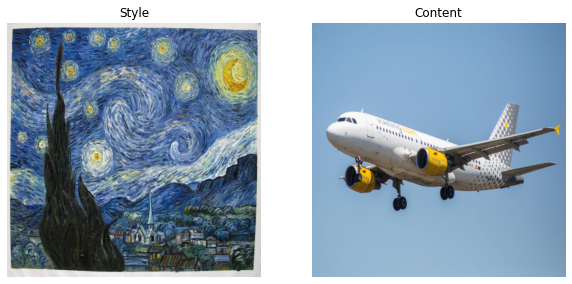

In [ ]:
# Call the show_images function on the style and content images.
show_images([style_image, content_image], ['Style', 'Content'])

Now we're ready to write a function which, given an image, extracts intermediate features with the help of the model.

Since the model was trained on images with normalized pixel values, we'll first normalize the pixel values in our image. Next, we'll iterate over the layers in the model. If the layer is a convolution, we'll take the intermediate feature after the convolution and store in our `features` list. We'll stop after 7 convolutions.

In [ ]:
def extract_features(image, model, detach=True):
  image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
  features = []
  num_conv = 0
  for layer in model.children():    
    image = layer(image)
    if isinstance(layer, torch.nn.Conv2d):
      num_conv += 1
      features += [image.detach() if detach else image]
    # There are a lot of convolutional layers,
    # add code so that we stop after 7 convolutional layers.
    if num_conv >= 7: break
  return features

In this function, we have the option to "detach" a variable from its gradient. If we don't want to compute the gradient of the loss with respect to a variable, then we'll use detach.

In order to calculate the gram matrix, we'll write a helper function which converts one of our singleton batches of dimension $a \times b \times c \times d$ to a gram matrix. First, because there's only one image, we know the batch size $a=1$. Then, we'll reformat the row column dimensions $c$ and $d$ so the resulting matrix is $b \times cd$. Once in this form, we can compute the gram matrix.

In [ ]:
def gram_matrix(x):
  a,b,c,d = x.size()
  # a is batch size
  # b is number of channels
  # (c,d) is the shape of the channels

  # Build a new matrix with dimension (b,cd).
  # Hint: The .view method is your friend.
  x_resized = x.view(-1, c*d)
  # Compute the gram matrix of the new matrix you just built.
  # Hint: The resulting matrix should have dimension (b,b). Make sure to confirm!
  gram = x_resized @ x_resized.T
  # Normalize the gram matrix using the number of elements in x.
  # Hint: The .numel method is your friend.
  gram *= 1/x.numel()
  return gram

In [ ]:
def calculate_loss(generated_features, style_features, content_features):
  style_loss, content_loss = 0, 0
  
  # Iterate over features at each layer
  for i in range(len(generated_features)):
    # Calculate the content loss and add it to content_loss.
    content_loss += F.mse_loss(generated_features[i], content_features[i])
    # Build the gram matrix for the generated features and style features.
    # Hint: Use the gram_matrix function you just defined.
    generated_gram = gram_matrix(generated_features[i])
    style_gram = gram_matrix(style_features[i])
    # Compute the style loss and add it to style_loss.
    style_loss += F.mse_loss(generated_gram, style_gram)

  return style_loss, content_loss

Now that we have a way of computing the loss, we're almost ready to begin training. First, though, we'll have to do some set up.

In [ ]:
# Initialize generated_image as a bunch of normal random noise.
# Ensure the generated image is the same size as content_image AND is on the device.
generated_image = content_image.clone()
generated_image = torch.randn(content_image.data.size(), device=device)
# We'll flag the pixels in generated_image as requiring gradients
# so we compute compute the partial derivative of the loss with respect to the pixels.
generated_image.requires_grad_(True)

Because it works better, we'll use an optimizer called the Limited-memory Broyden–Fletcher–Goldfarb–Shanno. The optimizer uses several first order derivatives to approximate second order information and, you guessed it, doesn't take too much space. The optimizer will use change the pixels in `generated_image`.

In [ ]:
optimizer = torch.optim.LBFGS([generated_image])

Since the style and content images don't change, we can extract their intermediate features from the model once.

In [ ]:
style_features = extract_features(style_image, model, detach=True)
content_features = extract_features(content_image, model, detach=True)

Notice that we detach the style and content features from their gradients. This is because we want to compute the gradient of the loss with respect to the pixel's of the image that we're changing (not the fixed style and content images).

Finally, we're ready to train. By default, we'll run for 500 steps and use a `style_weight` of $1\times10^5$. Increasing this value will put more emphasis on the style loss will decreasing will put more emphasis on the content loss.

The LBFGS optimizer is implemented slightly strangely so we'll need to put the optimization steps inside a closure function which we pass to the optimizer. As usual, we will need to:

* zero the gradient (so we don't keep moving in the same direction),

* compute the loss,

* backpropagate to efficiently get the gradient,

* and take a step in the *pixel space* of the generated image.

In addition, we need to make sure that the pixel values can always be interpreted as colors. So we will *project* back into the valid pixel space before each step.

In [ ]:
num_steps = 500
style_weight = 1e5 # This is a hyperparameter you can tune.
run = [0]
while run[0] <= num_steps:
  def closure():
    # Project back to the valid range of pixels.
    with torch.no_grad():
      generated_image.clamp_(0,1)
    # Zero the gradient.
    optimizer.zero_grad()
    # Extract the generated features.
    # Hint: make sure we are keeping the gradient (i.e. NOT detaching).
    generated_features = extract_features(generated_image, model, detach=False) 
    # Compute style_loss and content_loss using the calculate_loss function.
    style_loss, content_loss = calculate_loss(generated_features, style_features, content_features)
    # Combine the loss.
    loss = style_loss * style_weight + content_loss
    # Backpropagate.
    loss.backward()

    run[0] += 1
    # A nice print statement with the losses and images.
    if run[0] % 10 == 0:
      print(f'run: {run}')
      print(f'Style Loss: {style_loss.item()} \t Content Loss: {content_loss.item()}')
      print()
      show_images(
          [style_image, generated_image, content_image],
          ['Style', 'Generated', 'Content'], num=run[0]
      )
    
    return loss

  optimizer.step(closure)

# Project into the pixel space one last time.
with torch.no_grad():
  generated_image.clamp_(0, 1)

Output hidden; open in https://colab.research.google.com to view.

Look at that! It's as if we asked van Gogh to paint an airplane. 

## Personalizing the Generated Image

Now play around with some style and content images of your choice. You should change:

* The style and content links to other images from the web.

* How many convolutional layers you use.

* The `style_weight` that allows us to trade off between style and content.

* The number of steps that we train for.

## Saving the Process

It's really fun to watch the image generate. If you'd like, you can run the following code to turn the images we saved along the way into a `.avi` video.

Once you generate it, you can download the video by clicking the folder icon on the left and then selecting the `Download` option from the three dots when you hover over `video.avi`. To watch the video, I had to use a website like [CloudConvert](https://cloudconvert.com/avi-to-mp4) to upload the `avi` version and download an `mp4` version.

In [ ]:
# Code adapted from https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
save_video = False

if save_video:
  image_folder = '/content/images/'
  video_name = 'video.avi'
  
  images = sorted([img for img in os.listdir(image_folder) if img.endswith(".jpg")])
  frame = cv2.imread(os.path.join(image_folder, images[0]))
  height, width, layers = frame.shape
  
  video = cv2.VideoWriter(video_name, 0, 1, (width,height))
  
  for image in images:
      video.write(cv2.imread(os.path.join(image_folder, image)))
  
  cv2.destroyAllWindows()
  video.release()